Question 2

In [1]:
import numpy as np

In [46]:
def matrix_sqrt(A):

    eigenvalues, eigenvectors = np.linalg.eigh(A)
    sqrt_eigenvalues = np.sqrt(eigenvalues).real
    Lambda_sqrt = np.diag(sqrt_eigenvalues)
    A_sqrt = eigenvectors @ Lambda_sqrt @ eigenvectors.T
    return A_sqrt

In [47]:
def fid(mu1, mu2, sigma1, sigma2):
    mean_diff = np.sum((mu1 - mu2)**2)
    sigma1_sqrt = matrix_sqrt(sigma1)
    sigma2_sqrt = matrix_sqrt(sigma2)
    trace_term = np.trace(sigma1 + sigma2 - 2 * matrix_sqrt(sigma1_sqrt @ sigma2 @ sigma1_sqrt))
    fid = mean_diff + trace_term
    return fid

In [48]:
mu1 = np.random.randn(10)
mu2 = np.random.randn(10)
sigma1 = np.random.randn(10,2048)
sigma1 = sigma1 @ sigma1.T
sigma2 = np.random.randn(10,2048)
sigma2 = sigma2 @ sigma2.T

fid_score = fid(mu1, mu2, sigma1, sigma2)
print("FID Score:", fid_score)

FID Score: 77.03817468363654


Question 3

In [49]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [50]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, variational = True):
        super(Encoder, self).__init__()
        self.variational = variational
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        if self.variational:
            return self.fc21(h), self.fc22(h)
        else:
            return self.fc21(h), None
            

In [51]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = F.relu(self.fc3(z))
        g = torch.sigmoid(self.fc4(h))
        return torch.clamp(g, min=0.1, max=0.9)
        

In [52]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, variational):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, variational)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)
        self.variational = variational

    def sampling(self, mu, logvar):
        if self.variational:
            std = torch.exp(0.5 * logvar)
            eps1 = torch.randn_like(std)
            eps2 = torch.randn_like(std)
            return 0.5 * ((eps1 * std + mu) + eps2 * std + mu)
        else:
            return mu

    def forward(self, x):
        mu, logvar = self.encoder(x)
        if self.variational:
            z = self.sampling(mu, logvar)
        else:
            z = mu
        return self.decoder(z), mu, logvar if logvar is not None else torch.zeros_like(mu)
            
        

In [67]:
def train(model, data_loader, epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    reconstruction_loss = nn.BCELoss(reduction = 'sum')
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, __) in enumerate(data_loader):
            data = data.view(data.size(0), -1)
            optimizer.zero_grad()
            reconstructed, mu, logvar = model(data)
            BCE = reconstruction_loss(reconstructed, data)
            KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = BCE + KLD
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f'Epoch {epoch}, Loss: {train_loss / len(data_loader.dataset)}')
        

In [55]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import binarize

def get_mnist_dataloaders(batch_size=1000):
    mnist_data = np.float32(np.load("MNIST_data.npy")) / 255
    mnist_labels = np.load("MNIST_labels.npy")

    mnist_data = binarize(mnist_data, threshold=0.5)
    mnist_data = mnist_data.reshape(-1, 1, 28, 28)  # Reshape data for image format

    data_train, data_temp, labels_train, labels_temp = train_test_split(mnist_data, mnist_labels, test_size=0.4, random_state=42)
    data_val, data_test, labels_val, labels_test = train_test_split(data_temp, labels_temp, test_size=0.5, random_state=42)

    data_train, labels_train = torch.tensor(data_train), torch.tensor(labels_train, dtype=torch.long)
    data_val, labels_val = torch.tensor(data_val), torch.tensor(labels_val, dtype=torch.long)
    data_test, labels_test = torch.tensor(data_test), torch.tensor(labels_test, dtype=torch.long)

    train_dataset = TensorDataset(data_train, labels_train)
    val_dataset = TensorDataset(data_val, labels_val)
    test_dataset = TensorDataset(data_test, labels_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, test_dataset

train_loader, val_loader, test_loader, test_dataset = get_mnist_dataloaders()



In [56]:
model = VAE(784, 128, 8, True)
train(model, train_loader, epochs=50, learning_rate = 0.001)

Epoch 0, Loss: 356.6415539434524
Epoch 1, Loss: 250.06711867559522
Epoch 2, Loss: 230.47962351190475
Epoch 3, Loss: 213.3987615327381
Epoch 4, Loss: 202.48427157738095
Epoch 5, Loss: 197.1060904017857
Epoch 6, Loss: 193.3572380952381
Epoch 7, Loss: 190.13112276785714
Epoch 8, Loss: 187.59474330357142
Epoch 9, Loss: 185.66288950892857
Epoch 10, Loss: 184.09343191964285
Epoch 11, Loss: 182.81533482142856
Epoch 12, Loss: 181.68924107142857
Epoch 13, Loss: 180.77230766369047
Epoch 14, Loss: 179.9761011904762
Epoch 15, Loss: 179.24118303571427
Epoch 16, Loss: 178.59578385416665
Epoch 17, Loss: 178.0071402529762
Epoch 18, Loss: 177.4735509672619
Epoch 19, Loss: 176.9565509672619
Epoch 20, Loss: 176.5197388392857
Epoch 21, Loss: 176.06757998511904
Epoch 22, Loss: 175.6842886904762
Epoch 23, Loss: 175.29569382440476
Epoch 24, Loss: 174.92235119047618
Epoch 25, Loss: 174.5514110863095
Epoch 26, Loss: 174.22237016369047
Epoch 27, Loss: 173.92991927083332
Epoch 28, Loss: 173.64915848214287
Epoch 

Part B

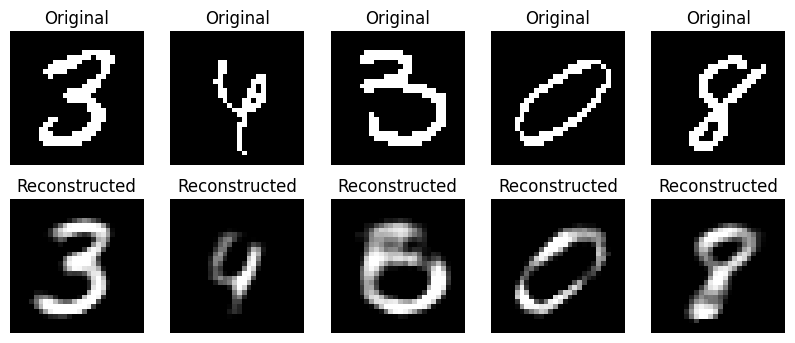

In [58]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(data.size(0), -1)
        reconstructed, _, _ = model(data)
        break

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    axes[0, i].imshow(data[i].reshape(28, 28), cmap='gray')
    axes[1, i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].axis('off')
    axes[0, i].set_title('Original')
    axes[1, i].set_title('Reconstructed')
plt.show()

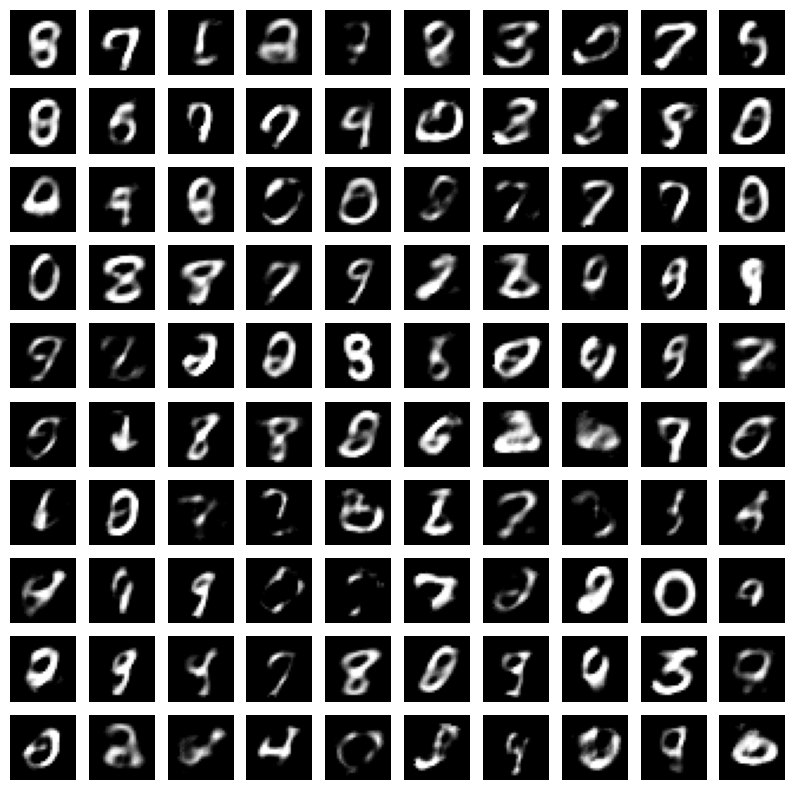

In [59]:
model.eval()
with torch.no_grad():
    z = torch.randn(100, 8)
    samples = model.decoder(z)

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()



In [65]:
hidden_dims = [128, 256, 512]
embedding_dims = [10, 40]

models = {}
for h_dim in hidden_dims:
    for e_dim in embedding_dims:
        model_key = f"VAE_h{h_dim}_d{e_dim}"
        models[model_key] = VAE(input_dim=784, hidden_dim=h_dim, latent_dim=e_dim, variational=True)
        train(models[model_key], train_loader, epochs=50, learning_rate=0.001)
        
def get_statistics(samples):
    if samples.ndim > 2:
        samples = samples.reshape(samples.shape[0], -1)
    mu = np.mean(samples, axis=0)
    sigma = np.cov(samples, rowvar=False) + 1e-6 * np.eye(samples.shape[1])
    return mu, sigma


def generate_samples(model, num_samples=1000):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim)
        samples = model.decoder(z).cpu().numpy()
    return samples

real_samples = next(iter(DataLoader(test_dataset, batch_size=1000)))[0].numpy()
real_mu, real_sigma = get_statistics(real_samples)

generated_stats = {}
fid_scores = {}
for model_key, model in models.items():
    gen_samples = generate_samples(model)
    gen_mu, gen_sigma = get_statistics(gen_samples)
    generated_stats[model_key] = (gen_mu, gen_sigma)
    fid_scores[model_key] = fid(real_mu, gen_mu, real_sigma, gen_sigma)
    

for key, score in fid_scores.items():
    print(f"FID score for {key}: {score}")

Epoch 0, Loss: 358.17767782738093
Epoch 1, Loss: 251.59973102678572
Epoch 2, Loss: 230.52558072916668
Epoch 3, Loss: 215.57628608630952
Epoch 4, Loss: 205.20320535714285
Epoch 5, Loss: 197.0901257440476
Epoch 6, Loss: 191.79015029761905
Epoch 7, Loss: 188.31725186011906
Epoch 8, Loss: 185.42540104166667
Epoch 9, Loss: 183.20782626488096
Epoch 10, Loss: 181.4125383184524
Epoch 11, Loss: 179.88517745535714
Epoch 12, Loss: 178.50718117559524
Epoch 13, Loss: 177.24852901785715
Epoch 14, Loss: 176.1751599702381
Epoch 15, Loss: 175.26821205357143
Epoch 16, Loss: 174.454796875
Epoch 17, Loss: 173.7961439732143
Epoch 18, Loss: 173.14152938988096
Epoch 19, Loss: 172.5952883184524
Epoch 20, Loss: 172.11271577380953
Epoch 21, Loss: 171.69637983630952
Epoch 22, Loss: 171.23280133928571
Epoch 23, Loss: 170.83083779761904
Epoch 24, Loss: 170.47996354166668
Epoch 25, Loss: 170.12304389880953
Epoch 26, Loss: 169.78902790178572
Epoch 27, Loss: 169.48134895833334
Epoch 28, Loss: 169.13848251488096
Epoch

In [81]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, variational=True):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # Latent vector
        self.fc22 = nn.Linear(hidden_dim, latent_dim) if variational else None  # Only needed for VAE

    def forward(self, x):
        h = F.relu(self.fc1(x))
        if self.fc22 is None:
            return self.fc21(h)  
        else:
            return self.fc21(h), self.fc22(h)  

In [82]:
class AE(nn.Module):
    def __init__(self, input_dim = 784, hidden_dim = 256, latent_dim = 10):
        super(AE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, variational = False)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        z = self.encoder(x)[0]
        return self.decoder(z)

ae_model = AE()


In [83]:
import torch.optim as optim
import torch.nn.functional as F

def train_ae(model, data_loader, epochs=50, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.view(data.size(0), -1)  # Flatten the data
            optimizer.zero_grad()
            reconstructed = model(data)  # Only expect the reconstructed output
            loss = F.binary_cross_entropy(reconstructed, data, reduction='sum')  # Assume using BCE for reconstruction loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        print(f'Epoch {epoch + 1}, Loss: {train_loss / len(data_loader.dataset)}')


In [84]:
def encode_data(model, data_loader):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for batch in data_loader:
            data = batch[0].view(batch[0].size(0), -1)
            embedding = model.encoder(data)[0]
            embeddings.append(embedding)
    embeddings = torch.cat(embeddings).numpy()
    return embeddings

encoded_data = encode_data(ae_model, train_loader)



In [100]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components = 10, covariance_type = 'full')
print(encoded_data.shape)
encoded_data = encoded_data.reshape(42,10)
print(encoded_data.shape)
gmm.fit(encoded_data)


(420,)
(42, 10)


GaussianMixture(n_components=10)

In [102]:
def decode_samples(model, gmm, num_samples):
    model.eval()
    with torch.no_grad():
        sampled_z = torch.from_numpy(gmm.sample(num_samples)[0]).float()
        print("Sampled zs shape:", sampled_z.shape)

        if sampled_z.dim() == 1:
            sampled_z = sampled_zs.unsqueeze(1)
        if sampled_z.shape[1] != 10:
            raise ValueError(f"Expected latent to be 10, but got {sampled_z.shape[1]}")

        generated_samples = model.decoder(sampled_z).cpu().numpy()
    return generated_samples.reshape(num_samples, 28, 28)

generated_images = decode_samples(ae_model, gmm, 1000)

real_samples = next(iter(test_loader))[0].numpy().reshape(1000, 784)
real_mu = real_sigma = get_statistics(real_samples)
gen_mu, gen_sigma = get_statistics(generated_images.reshape(1000, 784))

print("Shape of real_mu:", real_mu.shape)
print("Shape of gen_mu:", gen_mu.shape)
print("Shape of real_sigma:", real_sigma.shape)
print("Shape of gen_sigma:", gen_sigma.shape)

fid_score = fid(real_mu, gen_mu, real_sigma, gen_sigma)
print(f"FID Score: {fid_score}")

Sampled zs shape: torch.Size([1000, 10])


AttributeError: 'tuple' object has no attribute 'shape'